## INFERENCE

In [1]:
from my_utils.datasets import *
import cv2
import numpy as np
from models import Darknet
import torch
from torchvision import transforms as transforms
import torchvision

img_size = 512
file_name = '/home/mengtingx/zt/yolov3/asserts/img_17247.jpg'
img0 = cv2.imread(file_name)
img = letterbox(img0, new_shape=img_size)[0]
#img = img / 255.0
print(img.shape)
img = img[:, :, ::-1]  # BGR to RGB, to 3x416x416
#img = np.ascontiguousarray(img)
img = transforms.ToTensor()(np.array(img))
img = img.unsqueeze(0).cuda()


model = Darknet('trained_models/yolov3-spp-default/yolov3-spp-44.cfg', img_size=img_size)
model.load_state_dict(torch.load('trained_models/yolov3-spp-default/best.pt')['model'])
model = model.cuda()
model.eval()

torchvision.utils.save_image(img, 'input.jpg')

img_test = torch.zeros((1, 3, img_size, img_size)).cuda()
model(img_test)

pred = model(img)[0]

print(pred[0,:4,:4])


(320, 512, 3)
Model Summary: 225 layers, 6.28049e+07 parameters, 6.28049e+07 gradients
tensor([[ 21.65791,  22.68403,  53.77603,  46.55591],
        [ 46.32964,  20.55638,  96.22660,  41.65279],
        [ 73.98700,  21.49123, 145.46205,  45.83110],
        [109.94425,  21.35862, 175.42081,  43.42484]], device='cuda:0', grad_fn=<SliceBackward>)


## VAL DATASET

command: python3 test.py --cfg trained_models/yolov3-spp-default/yolov3-spp-44.cfg --data data/rubbish.data --weights trained_models/yolov3-spp-default/best.pt --batch-size 8

In [ ]:
import json

from torch.utils.data import DataLoader

from models import *
from my_utils.datasets import *
from my_utils.utils import *

## python3 test.py --cfg yolov3-44.cfg --data data/rubbish.data --weights trained_models/yolo-v3-60e/best.pt --batch-size 8

def test(cfg,
         data,
         weights=None,
         batch_size=16,
         imgsz=416,
         conf_thres=0.001,
         iou_thres=0.6,  # for nms
         save_json=False,
         single_cls=False,
         augment=False,
         model=None,
         dataloader=None):
    # Initialize/load model and set device
    if model is None:
        device = torch_utils.select_device('cuda', batch_size=batch_size)
        verbose = True

        # Remove previous
        for f in glob.glob('test_batch*.jpg'):
            os.remove(f)

        # Initialize model
        model = Darknet(cfg, imgsz)

        # Load weights
        attempt_download(weights)
        if weights.endswith('.pt'):  # pytorch format
            model.load_state_dict(torch.load(weights, map_location=device)['model'])
        elif weights.endswith('.pkl'):
            model.load_state_dict(torch.load(weights, map_location=device))
        else:  # darknet format
            load_darknet_weights(model, weights)

        # Fuse
        model.fuse()
        model.to(device)

        if device.type != 'cpu' and torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    else:  # called by train.py
        device = next(model.parameters()).device  # get model device
        verbose = False

    # Configure run
    data = parse_data_cfg(data)
    nc = 1 if single_cls else int(data['classes'])  # number of classes
    path = data['valid']  # path to test images
    names = load_classes(data['names'])  # class names
    iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if dataloader is None:
        dataset = LoadImagesAndLabels(path, imgsz, batch_size, rect=True, single_cls=False)
        batch_size = min(batch_size, len(dataset))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]),
                                pin_memory=True,
                                collate_fn=dataset.collate_fn)

    seen = 0
    model.eval()
    _ = model(torch.zeros((1, 3, imgsz, imgsz), device=device)) if device.type != 'cpu' else None  # run once
    s = ('%20s' + '%10s' * 6) % ('Class', 'Images', 'Targets', 'P', 'R', 'mAP@0.5', 'F1')
    p, r, f1, mp, mr, map, mf1, t0, t1 = 0., 0., 0., 0., 0., 0., 0., 0., 0.
    loss = torch.zeros(3, device=device)
    jdict, stats, ap, ap_class = [], [], [], []
    for batch_i, (imgs, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
        
        imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0
        targets = targets.to(device)
        nb, _, height, width = imgs.shape  # batch size, channels, height, width
        whwh = torch.Tensor([width, height, width, height]).to(device)

        # Disable gradients
        with torch.no_grad():
            # Run model
            t = torch_utils.time_synchronized()
            inf_out = model(imgs, augment=augment)[0]  # inference and training outputs
            t0 += torch_utils.time_synchronized() - t
            # Run NMS
            t = torch_utils.time_synchronized()
            ## output:
            ### list data for each images: (nx6 (x1, y1, x2, y2, conf, cls))
            output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres)  # nms
            t1 += torch_utils.time_synchronized() - t
            
            
        # Statistics per image
        """
        target with shape:
            n * 6 (image_index, label, bbox)
        """
        for si, pred in enumerate(output):
            ## 读取图像si的类别
            ## labels with shape: nl * 5 (label, bbox)
            labels = targets[targets[:, 0] == si, 1:]
            ## 计算obj个数
            nl = len(labels)
            ## 将target类标转成list格式
            tcls = labels[:, 0].tolist() if nl else []  # target class
            seen += 1

#             if pred is None:
#                 if nl:
#                     stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
#                 continue

            # Append to text file
            # with open('test.txt', 'a') as file:
            #    [file.write('%11.5g' * 7 % tuple(x) + '\n') for x in pred]

            # Clip boxes to image bounds
            # 将输出狂clip到图像大小
            clip_coords(pred, (height, width))

#             # Append to pycocotools JSON dictionary
#             if save_json:
#                 # [{"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78], "score": 0.236}, ...
#                 image_id = int(Path(paths[si]).stem.split('_')[-1])
#                 box = pred[:, :4].clone()  # xyxy
#                 scale_coords(imgs[si].shape[1:], box, shapes[si][0], shapes[si][1])  # to original shape
#                 box = xyxy2xywh(box)  # xywh
#                 box[:, :2] -= box[:, 2:] / 2  # xy center to top-left corner
#                 for p, b in zip(pred.tolist(), box.tolist()):
#                     jdict.append({'image_id': image_id,
#                                   'category_id': coco91class[int(p[5])],
#                                   'bbox': [round(x, 3) for x in b],
#                                   'score': round(p[4], 5)})

            # Assign all predictions as incorrect
            ## correct: [pred.shape[0], niou] => [[False]] 
            correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device=device)
            ## 如果有框
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]

                # target boxes
                ## 目标框 × whwh
                tbox = xywh2xyxy(labels[:, 1:5]) * whwh

                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ## 目标target=>类标为cls的位置
                    ti = (cls == tcls_tensor).nonzero().view(-1)  # prediction indices
                    ## 预测pred=>类标为cls的位置
                    pi = (cls == pred[:, 5]).nonzero().view(-1)  # target indices

                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ## 计算框之间的 iou
                        ## shape if pred:torch.Size([9, 6]), 
                        ## shape of target:torch.Size([1, 4]), 
                        ## shape of ious:torch.Size([9]) => 表示预测框与target之间的最大交集区域的iou
                        ## shape of i: torch.Size([9]) => 表示匹配的目标框位置。
                        ious, i = box_iou(pred[pi, :4], tbox[ti]).max(1)  # best ious, indices
#                         print("shape if pred:{}, shape of target:{}, shape of ious:{}".format(
#                             pred[pi].shape, tbox[ti].shape, ious.shape))
                        #print("value in ious:", ious)
                        # Append detections
                        ## 对于所有 与 gt 之间iou 大于0.5的框 
                        ## iouv = [0.5]
                        for j in (ious > iouv[0]).nonzero():
                            ## j 表示有效框
                            d = ti[i[j]]  # detected target
                            ## 对于所有目标框, 找到
                            if d not in detected:
                                detected.append(d)
                                ## 如果预测的框 pi[j] 与 ti[i[j]] 交集 iou 大于iouv 则认为检测正确
                                
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                                if len(detected) == nl:  # all targets already located in image
                                    break

            # Append statistics (correct, conf, pcls, tcls)
            ### correct: [pred_shape, iouv] 在指定 iou threshod 下，检测到的框是否是正确的
            pred[:, :4] = pred[:, :4] / whwh
            stats.append((correct.cpu(), pred[:, :5].cpu(), pred[:, 5].cpu(), labels.cpu()))

    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    return stats
#     print("shape of stats:", stats.shape)
#     if len(stats):
#         p, r, ap, f1, ap_class = ap_per_class(*stats)
#         if niou > 1:
#             p, r, ap, f1 = p[:, 0], r[:, 0], ap.mean(1), ap[:, 0]  # [P, R, AP@0.5:0.95, AP@0.5]
#         mp, mr, map, mf1 = p.mean(), r.mean(), ap.mean(), f1.mean()
#         nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
#     else:
#         nt = torch.zeros(1)

#     # Print results
#     pf = '%20s' + '%10.3g' * 6  # print format
#     print(pf % ('all', seen, nt.sum(), mp, mr, map, mf1))

#     # Print results per class
#     if verbose and nc > 1 and len(stats):
#         for i, c in enumerate(ap_class):
#             print(pf % (names[c], seen, nt[c], p[i], r[i], ap[i], f1[i]))

#     # Print speeds
#     if verbose or save_json:
#         t = tuple(x / seen * 1E3 for x in (t0, t1, t0 + t1)) + (imgsz, imgsz, batch_size)  # tuple
#         print('Speed: %.1f/%.1f/%.1f ms inference/NMS/total per %gx%g image at batch-size %g' % t)


#     # Return results
#     maps = np.zeros(nc) + map
#     for i, c in enumerate(ap_class):
#         maps[c] = ap[i]
#     return (mp, mr, map, mf1, *(loss.cpu() / len(dataloader)).tolist()), maps

cfg = 'trained_models/yolov3-spp-A/yolov3-spp-44.cfg'
data = 'data/rubbish.data' 
weights = 'trained_models/yolov3-spp-A/best.pt'
batch_size = 8
#data/rubbish.data --weights trained_models/yolov3-spp-default/best.pt

stats = test(cfg, data, weights, batch_size)

In [ ]:
print(stats[1].shape)
print(stats[-1].shape)

## SAVING stats and LOADING stats


In [ ]:
np.savez('states_spp_A.npz', d=stats)

In [ ]:
import numpy as np
data = np.load('states_spp_default.npz', allow_pickle=True)
stats = list(data['d'])


### Test FUnction Return
stats: list type 

    [correct, pred_obj, pred_cls, target_cls]
    
correct: True positives (nparray, nx1 or nx10).

### Following ...

calculate the mAP value, only under iou_threshold = 0.5

In [ ]:
from my_utils.utils import *
niou = 1
nc = 44  # number of classes
if len(stats):
    p, r, ap, f1, ap_class = ap_per_class(*stats)
    if niou > 1:
        p, r, ap, f1 = p[:, 0], r[:, 0], ap.mean(1), ap[:, 0]  # [P, R, AP@0.5:0.95, AP@0.5]
    mp, mr, map, mf1 = p.mean(), r.mean(), ap.mean(), f1.mean()
    nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
else:
    nt = torch.zeros(1)

seen =  1500
# Print results
# pf = '%20s' + '%10.3g' * 6  # print format
#print(pf % ('all', seen, nt.sum(), mp, mr, map, mf1))
print("mp, mr, map, mf1", mp, mr, map, mf1)

# # Print results per class
# if verbose and nc > 1 and len(stats):
#     for i, c in enumerate(ap_class):
#         print(pf % (names[c], seen, nt[c], p[i], r[i], ap[i], f1[i]))

# # Print speeds
# if verbose or save_json:
#     t = tuple(x / seen * 1E3 for x in (t0, t1, t0 + t1)) + (imgsz, imgsz, batch_size)  # tuple
#     print('Speed: %.1f/%.1f/%.1f ms inference/NMS/total per %gx%g image at batch-size %g' % t)


# # Return results
# maps = np.zeros(nc) + map
# for i, c in enumerate(ap_class):
#     maps[c] = ap[i]

## TP &  FP

TP: 预测框中 与 gt 框 的 iou>0.5的框个数

FP: 预测框中不满足上述要求的框个数

Recall: \frac{TP}{n_gt}

Precision: \frac{TP}{TP+FP}

In [ ]:
from my_utils.utils import *
tp, box_conf, pred_cls, target_box_cls = stats
conf = box_conf[:,-1]
target_cls = target_box_cls[:,0]
## 按照 object_confidence 从大到小排序
i = np.argsort(-conf)
tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

## 所有有目标的类别
unique_classes = np.unique(target_cls)


## 计算每个类别的ap, 基于不同的iou_threshold
s = [unique_classes.shape[0], tp.shape[1]] # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
ap, p, r = np.zeros(s), np.zeros(s), np.zeros(s)

## print(tp.shape)

## 对于所有的类
for ci, c in enumerate(unique_classes):
    ## 寻找 预测类标为c的 index
    i = (pred_cls == c)
    ## ground_truth 为 c 的个数
    n_gt = (target_cls == c).sum() ## 
    n_p = i.sum() ## pred 为 c 的个数
    
    if n_p == 0 or n_gt == 0:
            continue
    else:
        # Accumulate FPs and TPs
        ## FP
        fpc = (1 - tp[i]).cumsum(0)
        ## TP
        tpc = tp[i].cumsum(0)
        
        ## cumsum 表示 一个样本一个样本加进来
        
        recall = tpc / (n_gt + 1e-16)  # recall curve
        
        ## tpc + fpc 表示 pred中类标为c的个数
        ## print(tpc + fpc) => [1,...,num_bbox]
        precision = tpc / (tpc + fpc)  # precision curve
        
        #print("recall shape:{}, precision shape:{}".format(recall.shape, precision.shape))
        
        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j] = compute_ap(recall[:, j], precision[:, j])

        # Plot
#         fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#         ax.plot(recall, precision)
#         ax.set_xlabel('Recall')
#         ax.set_ylabel('Precision')
#         ax.set_xlim(0, 1.01)
#         ax.set_ylim(0, 1.01)
#         fig.tight_layout()
#         fig.savefig('PR_curve.png', dpi=300)
        
print(ap[:,0].mean())        

In [ ]:
x = np.arange(44)
ap50 = ap[:, 0]
print(ap50.shape)
from matplotlib import pyplot as plt
plt.bar(x, ap50, color='green')


np.argwhere(ap50<0.5)

## 计算不同大小size(small, medium, large) 的AP值

boxes size = h * w 

**small: boxes_size < 0.1**  label = 0

**medium: 0.1 < boxes_size < 0.3** label = 1

**large: boxes_size > 0.3** label = 2

### Conclusion:

yolov3-spp-default model:

    mAP_s: 0.7574319444870937

    mAP_m: 0.715568982172495

    mAP_l: 0.5086681573770104
    
    mAP: 0.6947982765080902

yolov3-spp-anchor model:

In [ ]:
import numpy as np
tp, box_conf, pred_cls, target_box_cls = stats
## xyxy
boxes = box_conf[:, :-1]
boxes_size = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

boxes_size_label = np.ones_like(boxes_size)

boxes_size_label[boxes_size < 0.1] = 0
boxes_size_label[boxes_size > 0.3] = 2

#xywh
target_boxes = target_box_cls[:,1:]
target_boxes_size = target_boxes[:, 2] * target_boxes[:, 3]
target_boxes_size_label = np.ones_like(target_boxes_size)

target_boxes_size_label[target_boxes_size < 0.1] = 0
target_boxes_size_label[target_boxes_size > 0.3] = 2


In [ ]:
from my_utils.utils import *
tp, box_conf, pred_cls, target_box_cls = stats
conf = box_conf[:,-1]
target_cls = target_box_cls[:,0]
## 按照 object_confidence 从大到小排序
i = np.argsort(-conf)
tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

size_label = -1

## 所有有目标的类别
unique_classes = np.unique(target_cls)


## 计算每个类别的ap, 基于不同的iou_threshold
s = [unique_classes.shape[0], tp.shape[1]] # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
ap, p, r = np.zeros(s), np.zeros(s), np.zeros(s)

## print(tp.shape)

## 对于所有的类
for ci, c in enumerate(unique_classes):
    ## 寻找 预测类标为c的 index
    #i = (pred_cls == c)
    if size_label in [0,1,2]:
        
        i = (boxes_size_label==size_label) & (pred_cls == c)
        ## ground_truth 为 c 的个数
        n_gt = ((target_boxes_size_label == size_label) & (target_cls == c)).sum() ## 
    else:
        i = (pred_cls == c)
        n_gt = (target_cls == c).sum() ## 

    n_p = i.sum() ## pred 为 c 的个数
    
    if n_p == 0 or n_gt == 0:
            continue
    else:
        # Accumulate FPs and TPs
        ## FP
        fpc = (1 - tp[i]).cumsum(0)
        ## TP
        tpc = tp[i].cumsum(0)
        
        ## cumsum 表示 一个样本一个样本加进来
        
        recall = tpc / (n_gt + 1e-16)  # recall curve
        
        ## tpc + fpc 表示 pred中类标为c的个数
        ## print(tpc + fpc) => [1,...,num_bbox]
        precision = tpc / (tpc + fpc)  # precision curve
        
        #print("recall shape:{}, precision shape:{}".format(recall.shape, precision.shape))
        
        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j] = compute_ap(recall[:, j], precision[:, j])

        # Plot
#         fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#         ax.plot(recall, precision)
#         ax.set_xlabel('Recall')
#         ax.set_ylabel('Precision')
#         ax.set_xlim(0, 1.01)
#         ax.set_ylim(0, 1.01)
#         fig.tight_layout()
#         fig.savefig('PR_curve.png', dpi=300)
        
print(ap[:,0].mean())        

## 上述计算AP_s, AP_m, AP_l可能有问题，下面重新尝试计算

### 1. model outputs

In [2]:
import json

from torch.utils.data import DataLoader

from models import *
from my_utils.datasets import *
from my_utils.utils import *

## python3 test.py --cfg yolov3-44.cfg --data data/rubbish.data --weights trained_models/yolo-v3-60e/best.pt --batch-size 8

def test(cfg,
         data,
         weights=None,
         batch_size=1,
         imgsz=512,
         conf_thres=0.001,
         iou_thres=0.6,  # for nms
         save_json=False,
         single_cls=False,
         augment=False,
         model=None,
         dataloader=None):
    # Initialize/load model and set device
    if model is None:
        device = torch_utils.select_device('cuda', batch_size=batch_size)
        verbose = True

        # Remove previous
        for f in glob.glob('test_batch*.jpg'):
            os.remove(f)

        # Initialize model
        model = Darknet(cfg, imgsz)

        # Load weights
        attempt_download(weights)
        if weights.endswith('.pt'):  # pytorch format
            model.load_state_dict(torch.load(weights, map_location=device)['model'])
        elif weights.endswith('.pkl'):
            model.load_state_dict(torch.load(weights, map_location=device))
        else:  # darknet format
            load_darknet_weights(model, weights)

        # Fuse
        model.fuse()
        model.to(device)

        if device.type != 'cpu' and torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    else:  # called by train.py
        device = next(model.parameters()).device  # get model device
        verbose = False

    # Configure run
    data = parse_data_cfg(data)
    nc = 1 if single_cls else int(data['classes'])  # number of classes
    path = data['valid']  # path to test images
    names = load_classes(data['names'])  # class names
    iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if dataloader is None:
        dataset = LoadImagesAndLabels(path, imgsz, batch_size, rect=True, single_cls=False)
        batch_size = min(batch_size, len(dataset))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]),
                                pin_memory=True,
                                collate_fn=dataset.collate_fn)

    seen = 0
    model.eval()
    _ = model(torch.zeros((1, 3, imgsz, imgsz), device=device)) if device.type != 'cpu' else None  # run once
    s = ('%20s' + '%10s' * 6) % ('Class', 'Images', 'Targets', 'P', 'R', 'mAP@0.5', 'F1')
    p, r, f1, mp, mr, map, mf1, t0, t1 = 0., 0., 0., 0., 0., 0., 0., 0., 0.
    loss = torch.zeros(3, device=device)
    jdict, stats, ap, ap_class = [], [], [], []
    
    outputs = []
    
    for batch_i, (imgs, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
        
        imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0
        targets = targets.to(device)
        nb, _, height, width = imgs.shape  # batch size, channels, height, width
        whwh = torch.Tensor([width, height, width, height]).to(device)

        # Disable gradients
        with torch.no_grad():
            # Run model
            t = torch_utils.time_synchronized()
            inf_out = model(imgs, augment=augment)[0]  # inference and training outputs
            t0 += torch_utils.time_synchronized() - t
            # Run NMS
            t = torch_utils.time_synchronized()
            ## output:
            ### list data for each images: (nx6 (x1, y1, x2, y2, conf, cls))
            output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres)  # nms
            t1 += torch_utils.time_synchronized() - t
            """
            output with type(list) and shape:
                n * 6 (xyxy， confidence, pcls)
            """
            
            # [{"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78], "score": 0.236}, ...
            for si, pred in enumerate(output):
                ## 对于每张图片
                pred = pred.clone()
                temp = {
                    'pred': pred[:, :4].tolist(), ## 输出bbox
                    'conf': pred[:,4].tolist(),## object confidence.
                    'preid': pred[:, -1].tolist(), ## 输出类别
                    'whwh': whwh.clone().tolist(), ## 输入图像大小
                    'target': targets[targets[:, 0] == si,1:].clone().tolist(), ##目标gt [cls, xyhw]
                    'path': paths[si],
                    'shapes': shapes[si] #原始图像大小
                }
                
                outputs.append(temp)
                
    return outputs

cfg = 'trained_models/yolov3-A/yolov3-44-A.cfg'
data = 'data/rubbish.data' 
weights = 'trained_models/yolov3-A/best.pt'
batch_size = 1
#data/rubbish.data --weights trained_models/yolov3-spp-default/best.pt

outputs = test(cfg, data, weights, batch_size)

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', total_memory=11016MB)

Model Summary: 222 layers, 6.17553e+07 parameters, 6.17553e+07 gradients
Fusing layers...


Caching labels (1497 found, 0 missing, 0 empty, 0 duplicate, for 1497 images): 100%|██████████| 1497/1497 [00:00<00:00, 12740.34it/s]
               Class    Images   Targets         P         R   mAP@0.5        F1:   0%|          | 0/1497 [00:00<?, ?it/s]

Model Summary: 150 layers, 6.1729e+07 parameters, 6.1729e+07 gradients


               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|██████████| 1497/1497 [00:24<00:00, 60.26it/s]


### 2. save & load output

In [13]:
# print(len(outputs))
# for key in outputs[0].keys():
#     print(type(outputs[0][key]))
with open('yolov3-A.output.json', 'w') as f:
    json.dump(outputs, f)

In [14]:
import json
with open('yolov3-A.output.json','r') as f:
    outputs = json.load(f)
    
print(len(outputs))

1497


### 3. 计算AP small, medium, large, all.

In [3]:
import torch
import numpy as np
from my_utils.utils import *
# Statistics per image
#obj_size_label 
## 0: SMALL, 1: MEDIUM, 2: LARGE, other: ALL
#obj_size_label = 'medium'

iouv = torch.linspace(0.5, 0.95, 10) # iou vector for mAP@0.5:0.95
iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
niou = iouv.numel()


def select_with_size(*args, size_label='small', input_format='xyxy'):
    
    targets = args[0]
    
    if input_format == 'xywh':
        target_size = targets[:, 3] * targets[:, 2]
    else:
        target_size = (targets[:, 3] - targets[:, 1]) * (targets[:, 2] - targets[:, 0])
    
    if size_label == 'small':
        target_size_ind = np.where(target_size < 0.1)
    elif size_label == 'medium':
        target_size_ind = np.where((target_size> 0.1) & (target_size <0.3))
    elif size_label == 'large':
        target_size_ind = np.where(target_size> 0.3)
    else:
        ##所有样本
        target_size_ind = np.where(target_size>=0)
    
    return [arg[target_size_ind] for arg in args]

def calculate_AP_size(outputs, obj_size_label):

    stats = []
    paths = []
    ## 对于每一个图像数据
    for si, output in enumerate(outputs):
        ## 准备数据 targets [cls_label, xywh]
        targets = torch.tensor(output['target'])
        ## pred: xyxy
        pred = torch.tensor(output['pred'])
        conf = torch.tensor(output['conf'])
        pred_cls = torch.tensor(output['preid'])
        whwh = torch.tensor(output['whwh'])
        path = output['path']


        ## 筛选
        ### tboxs = targets[:, 1:5] tlables = targets[:, 0]
        tboxs, tlabels = select_with_size(targets[:, 1:5], targets[:, 0], size_label = obj_size_label, input_format='xywh')
        pboxs, pconfs, plabels = select_with_size(pred/whwh, conf, pred_cls, size_label = obj_size_label, input_format='xyxy')

        pboxs = pboxs * whwh

        #print(pboxs.shape)
        ## 计算图像i中obj个数
        nl = len(tlabels)
        ## 将target类标转成list格式
        #tcls = labels[:, 0].tolist() if nl else []  # target class

        # Clip boxes to image bounds
        # 将输出 clip 到图像大小
        #print(pboxs[0])
        clip_coords(pboxs, whwh[1:3])
        #print(pboxs[0])

        # Assign all predictions as incorrect
        ## correct: [pred.shape[0], niou] => [[False]] 
        correct = torch.zeros(pboxs.shape[0], niou, dtype=torch.bool)
        ## 如果有框
        if nl:
            detected = []  # target indices
            #tcls_tensor = tlabels[:, 0]

            # target boxes
            ## 目标框xyxy × whwh
            tbox = xywh2xyxy(tboxs) * whwh

            # Per target class
            for cls in torch.unique(tlabels):
                
#                 if(cls==7):
#                     print(tlabels)
#                     print(tboxs)
                
                ## 目标target=>类标为cls的位置
                ti = (cls == tlabels).nonzero().view(-1)  # prediction indices
                ## 预测pred=>类标为cls的位置
                pi = (cls == plabels).nonzero().view(-1)  # target indices

                # Search for detections
                if pi.shape[0]:
                    # Prediction to target ious
                    ## 计算框之间的 iou
                    ## shape if pred:torch.Size([9, 6]), 
                    ## shape of target:torch.Size([1, 4]), 
                    ## shape of ious:torch.Size([9]) => 表示预测框与target之间的最大交集区域的iou
                    ## shape of i: torch.Size([9]) => 表示匹配的目标框位置。
                    ious, i = box_iou(pboxs[pi], tbox[ti]).max(1)  # best ious, indices
    #                         print("shape if pred:{}, shape of target:{}, shape of ious:{}".format(
    #                             pred[pi].shape, tbox[ti].shape, ious.shape))
                    #print("value in ious:", ious)
                    # Append detections
                    ## 对于所有 与 gt 之间iou 大于0.5的框 
                    ## iouv = [0.5]
                    for j in (ious > iouv[0]).nonzero():
                        ## j 表示有效框
                        d = ti[i[j]]  # detected target
                        ## 对于所有目标框, 找到
                        if d not in detected:
                            detected.append(d)
                            ## 如果预测的框 pi[j] 与 ti[i[j]] 交集 iou 大于iouv 则认为检测正确

                            correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                            if len(detected) == nl:  # all targets already located in image
                                break

        # Append statistics (correct, conf, pcls, tcls)
        ### correct: [pred_shape, iouv] 在指定 iou threshod 下，检测到的框是否是正确的
        stats.append((correct.cpu(), pconfs.cpu(), plabels.cpu(), tlabels.cpu()))
        #paths.append(path)

    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    return stats


0.30785361123913974
0.5442876200412141
0.792296026933334
0.7025410264942612

In [15]:
size_levels = ['small', 'medium', 'large', 'all']
mAPs = np.zeros([len(class_names), 0])

for size_level in size_levels:
    ## Compute mAP.
    stats = calculate_AP_size(outputs = outputs, obj_size_label = size_level)
    #print(stats[3])
    from my_utils.utils import *
    niou = 1
    nc = 44  # number of classes
    if len(stats):
        p, r, ap, f1, ap_class = ap_per_class(*stats)
        if niou > 1:
            p, r, ap, f1 = p[:, 0], r[:, 0], ap.mean(1), ap[:, 0]  # [P, R, AP@0.5:0.95, AP@0.5]
        mp, mr, map, mf1 = p.mean(), r.mean(), ap.mean(), f1.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)
    
    ap = ap.squeeze()
    
    print(map)
    
    if size_level == 'small':
        ap = np.insert(ap, 4, np.nan)
        ap = np.insert(ap, 8, np.nan)
#         ap = np.insert(ap, 9, np.nan)
#         ap = np.insert(ap, 15, np.nan)
#         ap = np.insert(ap, 34, np.nan)
    elif size_level == 'medium':
        ap = np.insert(ap, 13, np.nan)
#         ap = np.insert(ap, 4, np.nan)
#         ap = np.insert(ap, 22, np.nan)
    #print(ap.squeeze().shape)
    #print("mp, mr, map, mf1", mp, mr, map, mf1)
    
    mAPs = np.concatenate((mAPs, ap[:,np.newaxis]), axis=1)

#     for i in range(ap.shape[0]):
#         print(ap[i])
print(mAPs.shape)

    #print(ap[ap!=0].mean())

0.33685933404294627
0.6304372149324966
0.8050538714175116
0.7064970742415388
(44, 4)


In [ ]:
a = np.array([1,2,3.0])

np.insert(a,1,np.nan)

### 4. 统计不同类别不同size大小的个数（验证集）

In [5]:
## 读取类标
from my_utils.utils import *
class_names = load_classes('/home/mengtingx/dataset/rubbish_yolo/classes.names')
print(class_names)

['一次性快餐盒', '书籍纸张', '充电宝', '剩饭剩菜', '包', '垃圾桶', '塑料器皿', '塑料玩具', '塑料衣架', '大骨头', '干电池', '快递纸袋', '插头电线', '旧衣服', '易拉罐', '枕头', '果皮果肉', '毛绒玩具', '污损塑料', '污损用纸', '洗护用品', '烟蒂', '牙签', '玻璃器皿', '砧板', '筷子', '纸盒纸箱', '花盆', '茶叶渣', '菜帮菜叶', '蛋壳', '调料瓶', '软膏', '过期药物', '酒瓶', '金属厨具', '金属器皿', '金属食品罐', '锅', '陶瓷器皿', '鞋', '食用油桶', '饮料瓶', '鱼骨']


In [12]:
import numpy as np

targets = np.zeros([0,5])
for si, output in enumerate(outputs):
    target = np.array(output['target'])
    targets = np.concatenate((targets, target), axis=0)

size_levels = ['small', 'medium', 'large', 'all']
## 44 * 3
size_nums = np.zeros([len(class_names), len(size_levels)])
## cls, xywh
#print(targets[0])

for i, class_name in enumerate(class_names):
    for sind, size_level in enumerate(size_levels):
        target = select_with_size(targets[targets[:, 0] == i,1:], size_label=size_level, input_format='xywh')[0]
        size_nums[i, sind] = target.shape[0]
#print(size_nums)

# targets_temp = targets[targets[:, 0] == 7,1:]

results = np.concatenate((size_nums, mAPs), axis=1)

for index, result in enumerate(results):
    print(index,'-',class_names[index].ljust(9 - len(class_names[index])), ':', result)
    #print(len(class_names[index]))
# print(targets_temp)

# target = select_with_size(targets_temp, size_label='small', input_format='xywh')[0]
# print(target)    

0 - 一次性快餐盒 : [          9           7          14          30    0.016698     0.51885      0.8175     0.61069]
1 - 书籍纸张  : [          4           3           9          16     0.12254     0.17067     0.75713     0.51859]
2 - 充电宝    : [          6          17          25          48     0.22865     0.69993     0.86342     0.77559]
3 - 剩饭剩菜  : [        134          23          17         174      0.5242     0.67174     0.78616     0.62805]
4 - 包        : [          0           1          39          40         nan       0.995     0.91871     0.89996]
5 - 垃圾桶    : [          1           5           9          15       0.995     0.39511     0.68968     0.59206]
6 - 塑料器皿  : [         14          16          35          65     0.41072     0.75063     0.86684     0.73514]
7 - 塑料玩具  : [          1          23          20          44     0.33167     0.56421      0.8139     0.72785]
8 - 塑料衣架  : [          0           9          24          33         nan     0.52941     0.88818     0.91751]
9 - 

### 5. 查看结果比较差的类的可视化结果

[[    0.54911     0.50098     0.12277     0.26367]
 [    0.42187     0.50488      0.1183     0.27539]]
[         34          34]
/home/mengtingx/dataset/rubbish_yolo/images/img_16422.jpg


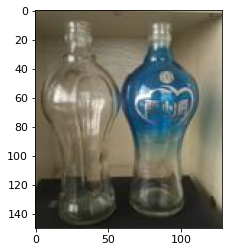

In [23]:
from PIL import Image
from matplotlib import pyplot as plt

size_level = 'small'

hard_class = [35,36,27]

num = 0
for i, output in enumerate(outputs):
    target = np.array(output['target'])
    tbox = target[:, 1:]
    tlabel = target[:, 0]
    
    tbox, tlabel = select_with_size(tbox, tlabel, size_label = size_level, input_format='xywh')
    
    path = output['path']
   
    if 34 in tlabel:
        print(tbox)
        print(tlabel)
        print(path)
#         print(output['shapes'])
#         print(output['whwh'])
        img = Image.open(path)
        plt.imshow(img)

        plt.show()
        num+=1
#         if num%10==9:
#             break;

In [ ]:
a = np.array([4,34])

34 in a

### Appendix: 测试 读取数据 接口